In [1]:
using CSV, DataFrames, PyPlot, PyCall, Glob, Statistics, LsqFit, Trapz

In [2]:
# Font selection and colours

# import necessary matplotlib modules
matplotlib = pyimport("matplotlib")
font_manager = pyimport("matplotlib.font_manager")
plt = pyimport("matplotlib.pyplot")

# path to arial (custom ttf)
font_path = "/home/mgadaloff/data_sharing/raw_data/Arial.ttf"

# create FontProperties object with arial
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

# assign arial as defualt figure font
rc("font", family=prop.get_name() ,size=12)

# colour gradients
reds = ["#4B0000", "#730000", "#9B0000", "#C20000", "#E00000", "#FF4040", "#FF8080", "#FFBFBF"]
greys = ["#1A1A1A", "#333333", "#4D4D4D", "#666666", "#808080", "#A6A6A6", "#CCCCCC", "#E5E5E5"]
blues = ["#000044", "#002277", "#0044AA", "#0066CC", "#3388FF", "#66AAFF", "#99CCFF", "#CCE6FF"];

In [3]:
# data processing and fitting functions

function extract_scan_rate(txt_file_path::String) # extracts scan rate from a text file
    open(txt_file_path, "r") do io # opens file in read mode ("r"); io is a handle (pointer) to the open file; do io syntax ensures file closes once operation complete
        for line in eachline(io)

            if occursin("Scan rate (dE/dt): ", line)

                parsed_strings = match(r"Scan rate \(dE/dt\): (\d+)", line) # isolates any digits after "Scan rate \(dE/dt\):"

                return parse(Float64, parsed_strings.captures[1])/1000 # converts strings to floats in V (rather than mV)
            end

        end
    end
end

function average_area(cv_df)

    cycles = unique(cv_df[!,:cycle]) # list of cycle numbers (labels)

    back_area_per_cycle = []
    for_area_per_cycle = []

    for cycle in cycles

        cv_df_one_cycle = filter(row -> row[:cycle] == cycle, cv_df) # isolate cycle
        row_index = argmin(cv_df_one_cycle.working_elec_V) # find turning point (end backward sweep)

        # area over forward and backward sweeps
        area_backward = trapz(reverse(cv_df_one_cycle.working_elec_V[1:row_index]), reverse(cv_df_one_cycle.abs_current_A[1:row_index]))
        area_forward = trapz(cv_df_one_cycle.working_elec_V[row_index+1:end], cv_df_one_cycle.abs_current_A[row_index+1:end])

        append!(back_area_per_cycle, area_backward)
        append!(for_area_per_cycle, area_forward)
    end

    # mean absolute forward and backward current over all cycles
    mean_area_per_cycle = mean(back_area_per_cycle .+ for_area_per_cycle) # mean CV area
    std_dev_area_per_scan_rate = std(back_area_per_cycle .+ for_area_per_cycle) # standard deviation CV area

    return mean_area_per_cycle, std_dev_area_per_scan_rate

end

function process_cyclic_v(cyclic_v_directory::String)

    # recursively find csv files
    csv_file_paths = [joinpath(root, file) for (root, _, files) in walkdir(cyclic_v_directory) for file in files if endswith(file, ".csv")]

    # import data and structure
    raw_data = Dict(csv_path => CSV.read(csv_path, DataFrame) for csv_path in csv_file_paths)

    # rename columns and remove first cycle
    for (csv_path, df_data) in raw_data

        rename!(df_data, [:step_num, :repeats, :cycle, :step_name, :elapsed_time_s, 
                    :working_elec_V, :working_elec_vs_NHE_V, :current_A, :abs_current_A, 
                    :current_den_A_per_m2, :cumulative_charge_mAh, :counter_electrode_V])
        
        filter!(row -> row[:cycle] != 0, df_data)

        if nrow(df_data) == 0 # throw error if cv does not complete cycle 0
            throw("cv halted during cycle 0: " * csv_path)
        end

    end

    # initialise dictionaries
    cv_data_restruc = Dict{Float64,DataFrame}()
    area_per_cycle = Dict{Float64, Float64}()
    std_dev_area_per_sweep_rate = Dict{Float64, Float64}()

    # compute average absolute current for each csv (separating forward and backward sweeps if necessary)
    for csv_path in csv_file_paths

        # specify csv parent directory and use to find all .txt files in same directory as csv
        parent_directory = splitdir(csv_path)[1]
        txt_file_path = [joinpath(root, file) for (root, _, files) in walkdir(parent_directory) for file in files if endswith(file, ".txt")]
        
        # parse .txt file to extract scan rate
        scan_rate = extract_scan_rate(txt_file_path[1])

        # assign cv data to dictionary
        cv_data_restruc[scan_rate] = raw_data[csv_path]

        # average charge per cycle and assign to dictionary
        mean_area_per_cycle, std_dev_area_per_scan_rate = average_area(raw_data[csv_path]) # mean CV area for each sweep rate
        area_per_cycle[scan_rate] = mean_area_per_cycle
        std_dev_area_per_sweep_rate[scan_rate] = std_dev_area_per_scan_rate

    end
    
    return cv_data_restruc, area_per_cycle, std_dev_area_per_sweep_rate

end;

function fit_line_through_origin(cap_data::Dict)

    sweep_rates = collect(keys(cap_data))
    area = collect(values(cap_data)).*10^6 # convert to μA

    # define line: y = mx (m is 2*ΔV*capacitance)
    linear_model(sweep_rates, p) = p[1] .* sweep_rates # p[1] = m

    # initial slope guess
    initial_slope = [0.2]

    # fit and extract slope
    fit = curve_fit(linear_model, sweep_rates, area, initial_slope)

    # extract fit parameter
    slope = fit.param[1]

    # capacitance
    capacitance = slope / (2 * 20) # ΔV = 20 (this could be made more accurate by using the recorded CV limits)

    # Generate fitted values
    sweep_fit = range(0,12, length=3)
    area_fit = linear_model(sweep_fit, fit.param)

    # compute R^2
    area_fit_for_r2 = linear_model(sweep_rates, fit.param)
    area_mean = mean(area)  # Mean of actual values
    ss_total = sum((area .- area_mean).^2)  # Total sum of squares
    ss_residual = sum((area .- area_fit_for_r2).^2)  # Residual sum of squares
    r_squared = 1 - (ss_residual / ss_total)

    return sweep_fit, area_fit, capacitance, r_squared

end;

function fit_line(x_data::Vector, y_data::Vector, x_range::Vector)

    # define line: y = mx + c
    linear_model(x_data, p) = p[1] .* x_data .+ p[2] # p[1] = m, p[2] = c

    # initial slope and intercept guesses
    initial_guesses = [1, 0.1]

    # fit and extract slope
    fit = curve_fit(linear_model, x_data, y_data, initial_guesses)

    # extract fit parameters
    slope = fit.param[1]
    intercept = fit.param[2]

    # Generate fitted values
    x_fit = range(x_range[1],x_range[2], length=3)
    y_fit = linear_model(x_fit, fit.param)

    # compute R^2
    y_fit_for_r2 = linear_model(x_data, fit.param)
    y_mean = mean(y_data)  # Mean of actual values
    ss_total = sum((y_data .- y_mean).^2)  # Total sum of squares
    ss_residual = sum((y_data .- y_fit_for_r2).^2)  # Residual sum of squares
    r_squared = 1 - (ss_residual / ss_total)

    return x_fit, y_fit, slope, intercept, r_squared

end;

In [7]:
# Figure 4 - Results

# CV approach: for each sweep rate, discard first cycle, average CV box area over remaining cycles

# specify search directory (fixed temperature, varying sweep rate) and process data
cv_directories = ["/home/mgadaloff/data_sharing/raw_data/capacitance/point_1", "/home/mgadaloff/data_sharing/raw_data/capacitance/point_2_25_08_No_1_166"]

# plotting
figure_1, axes_1 = plt.subplots(2, 2, figsize=(13, 10), dpi=800)

for i = 1:length(cv_directories)

    if i == 1
        colour_pal = greys
        colour = greys[3]
    else
        colour_pal = blues
        colour = blues[5]
    end

    cv_data, area_per_cycle, std_dev_area_per_sweep_rate = process_cyclic_v(cv_directories[i])
    sweep_fit, area_fit, capacitance, r2 = fit_line_through_origin(area_per_cycle)
    println("Device " * string(i) * " capacitance: " * string(round(capacitance*10, digits=4)) * "x 10^-7 F/cm2 and fit R2: " * string(round(r2, digits=4)))
    scan_rates = collect(keys(area_per_cycle))

    # plot data
    axes_1[2].scatter(scan_rates, collect(values(area_per_cycle)).*10^6, color=colour, s=10, label = "Device " * string(i) * " Data")
    axes_1[2].plot(sweep_fit, area_fit, color=colour, label = "Device " * string(i) * " Fit")

    axes_1[4].scatter(scan_rates, collect(values(std_dev_area_per_sweep_rate)).*10^6, color=colour, s=10, label = "Device " * string(i) * " Data")

    for index = 1:length(scan_rates)
        rate = sort(scan_rates, rev=true)[index]
        cv_data_per_cycle = cv_data[rate]

        if i == 1
            axes_index = 1
        else
            axes_index = 3
        end

        axes_1[axes_index].scatter(cv_data_per_cycle.working_elec_V, cv_data_per_cycle.current_A.*10^6, label=string(rate)*L" V s$\mathregular{^{-1}}$", s=10, color=colour_pal[index])
    end

end

axes_1[1].set_xlabel("Voltage / V", fontsize=14)
axes_1[1].set_ylabel(L"Current / (μA cm$\mathregular{^{-2}}$)", fontsize=14)
axes_1[1].set_xlim([-12, 12])
axes_1[1].set_ylim([-2.5, 3.5])
axes_1[1].set_xticks([-12, -8, -4, 0, 4, 8, 12])
axes_1[1].set_yticks([-2.5, -2, -1, 0, 1, 2, 3, 3.5])
axes_1[1].legend(ncol=3, loc="upper left")
axes_1[1].set_title("a) Device 1", fontsize=16, loc="left")

axes_1[3].set_xlabel("Voltage / V", fontsize=14)
axes_1[3].set_ylabel(L"Current / (μA cm$\mathregular{^{-2}}$)", fontsize=14)
axes_1[3].set_xlim([-12, 12])
axes_1[3].set_ylim([-2.5, 3.5])
axes_1[3].set_xticks([-12, -8, -4, 0, 4, 8, 12])
axes_1[3].set_yticks([-2.5, -2, -1, 0, 1, 2, 3, 3.5])
axes_1[3].legend(ncol=3, loc="upper left")
axes_1[3].set_title("b) Device 2", fontsize=16, loc="left")

axes_1[2].set_xlabel(L"Voltage Sweep Rate / (V s$\mathregular{^{-1}}$)", fontsize=14)
axes_1[2].set_ylabel(L"Mean CV Area  / (μW cm$\mathregular{^{-2}}$)", fontsize=14)
axes_1[2].set_xlim([0, 12])
axes_1[2].set_ylim([0, 80])
axes_1[2].legend(ncol=2, loc="upper left");
axes_1[2].set_title("c) Fit for capacitance", fontsize=16, loc="left")

axes_1[4].set_xlabel(L"Voltage Sweep Rate / (V s$\mathregular{^{-1}}$)", fontsize=14)
axes_1[4].set_ylabel(L"Standard Deviation CV Area  / (μW cm$\mathregular{^{-2}}$)", fontsize=14)
axes_1[4].set_xlim([0, 12])
axes_1[4].set_ylim([0, 1.2])
axes_1[4].legend(ncol=2, loc="upper left");
axes_1[4].set_title("d) CV area standard deviation", fontsize=16, loc="left")

figure_1.subplots_adjust(hspace=0.3)

figure_1.savefig("cyclic_v_results.pdf", bbox_inches="tight")

Device 1 capacitance: 1.117x 10^-7 F/cm2 and fit R2: 0.9589
Device 2 capacitance: 1.6798x 10^-7 F/cm2 and fit R2: 0.9916


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


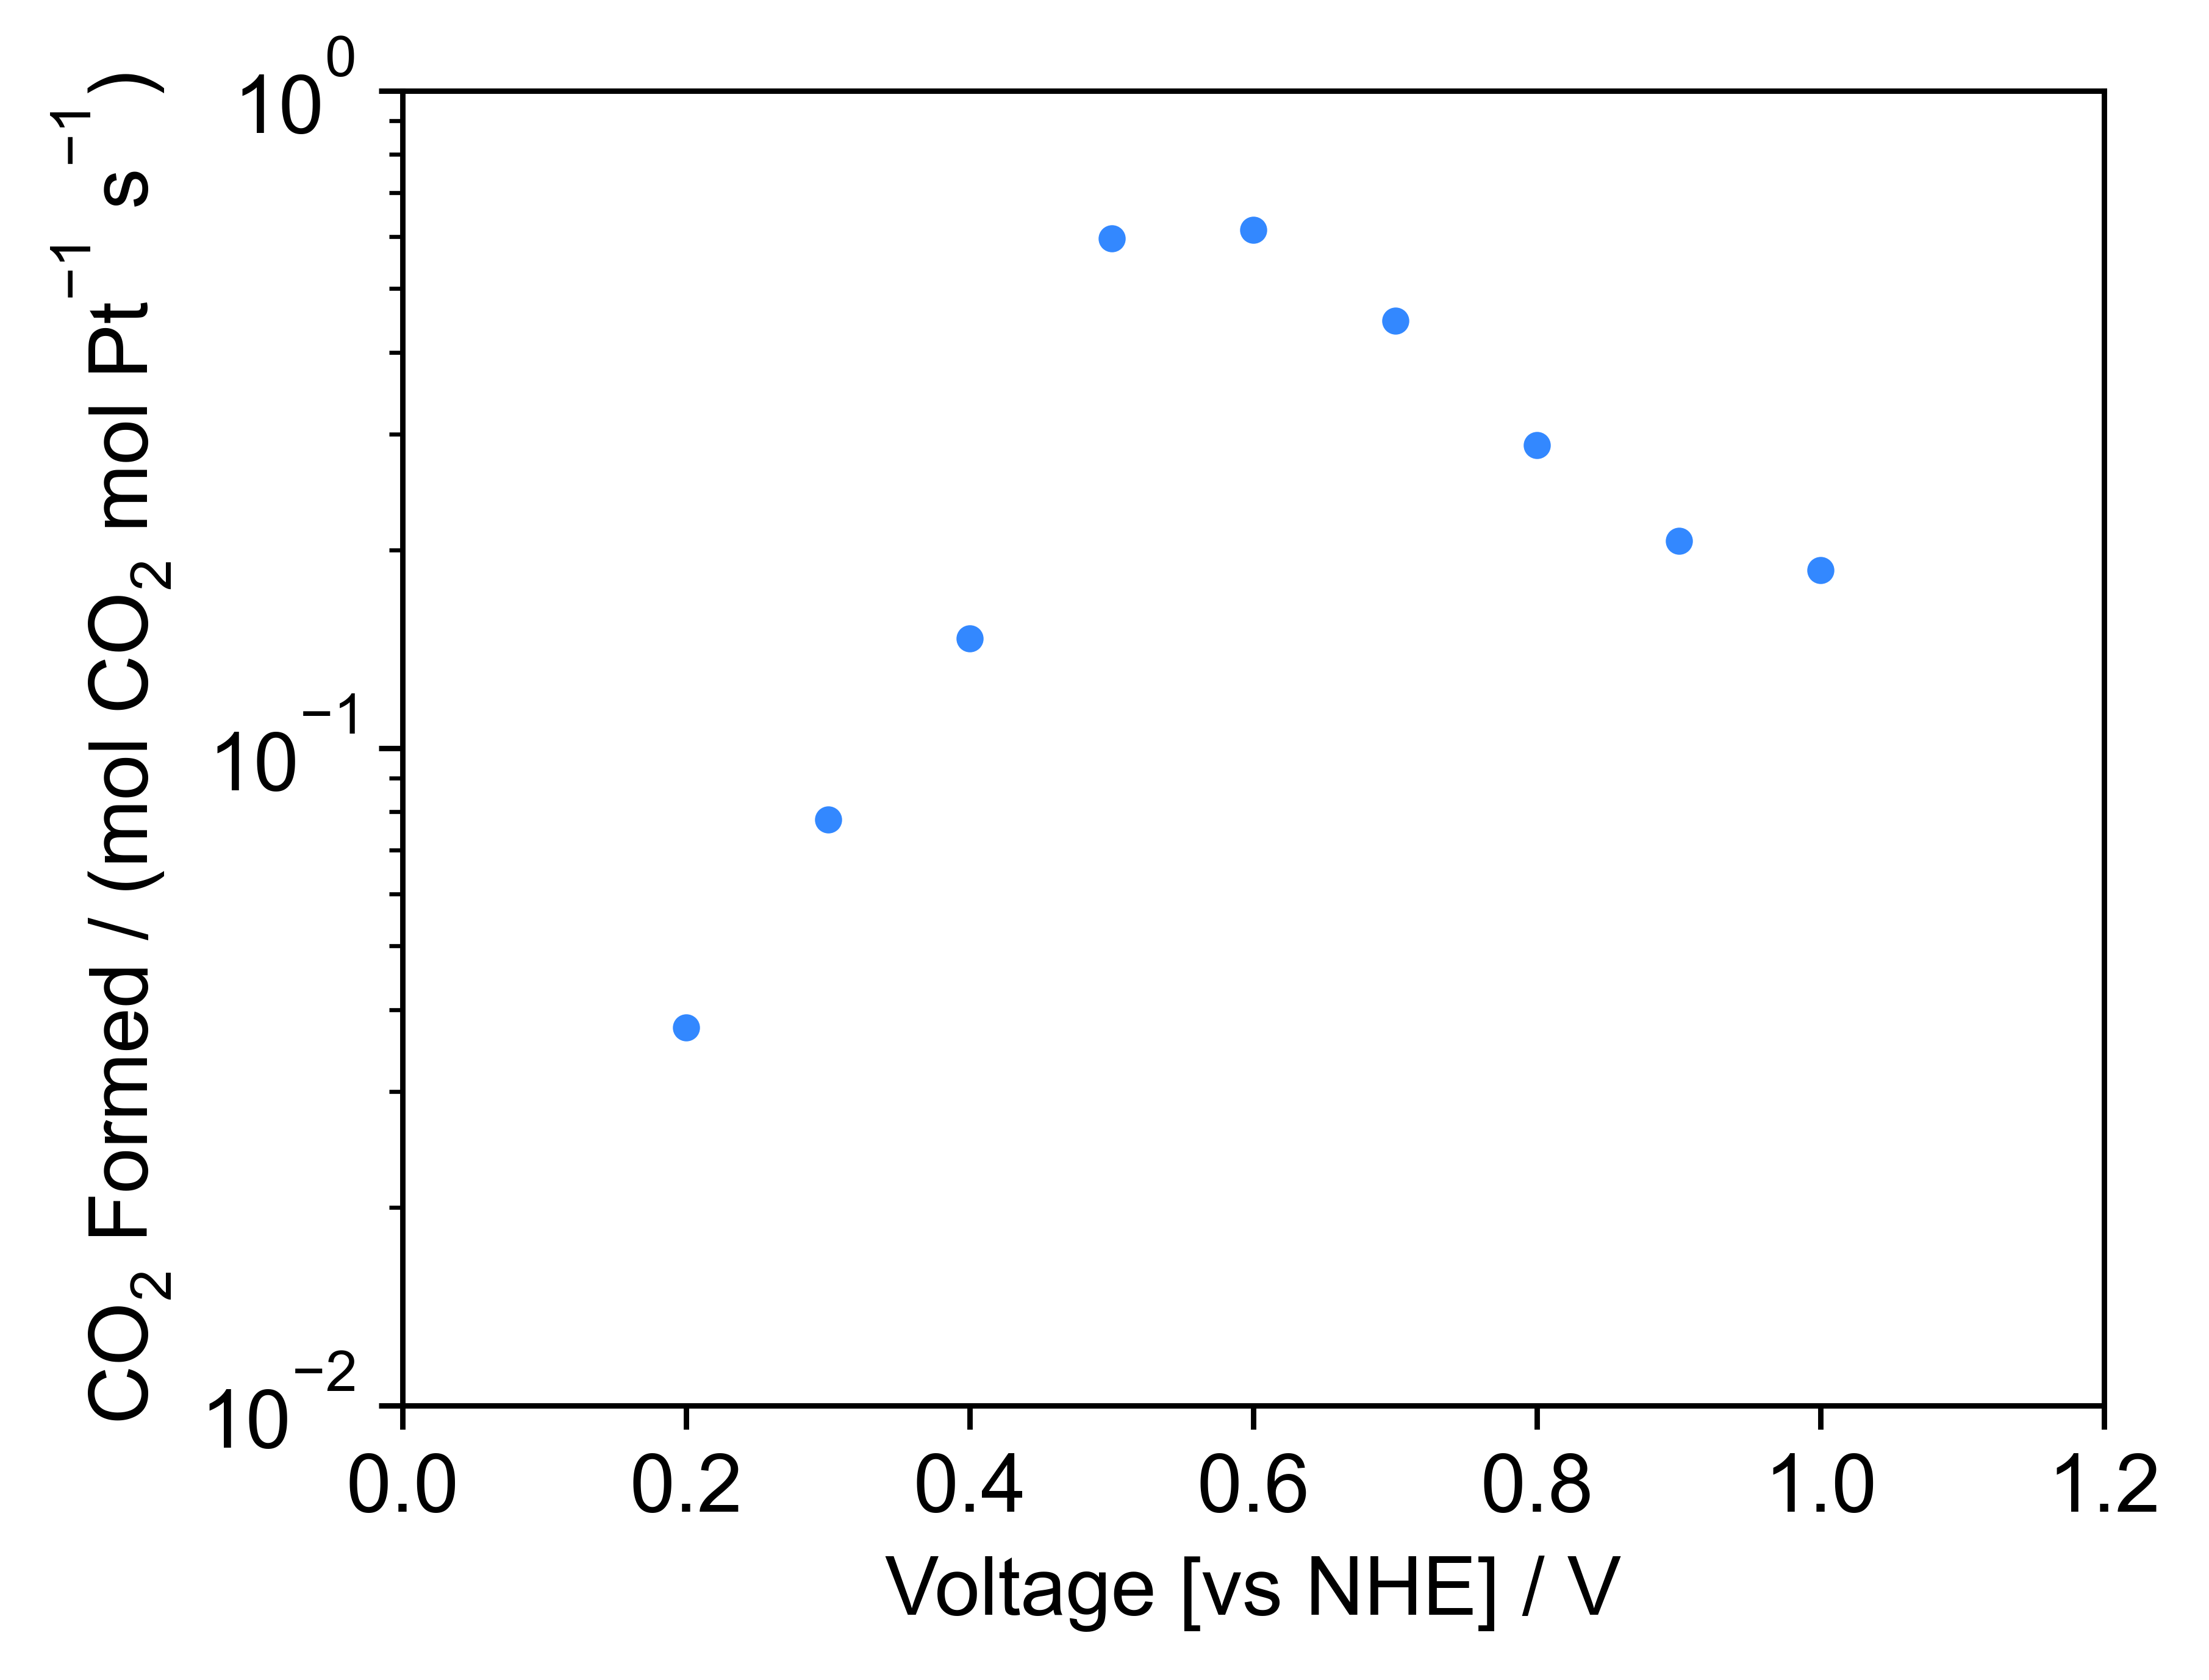

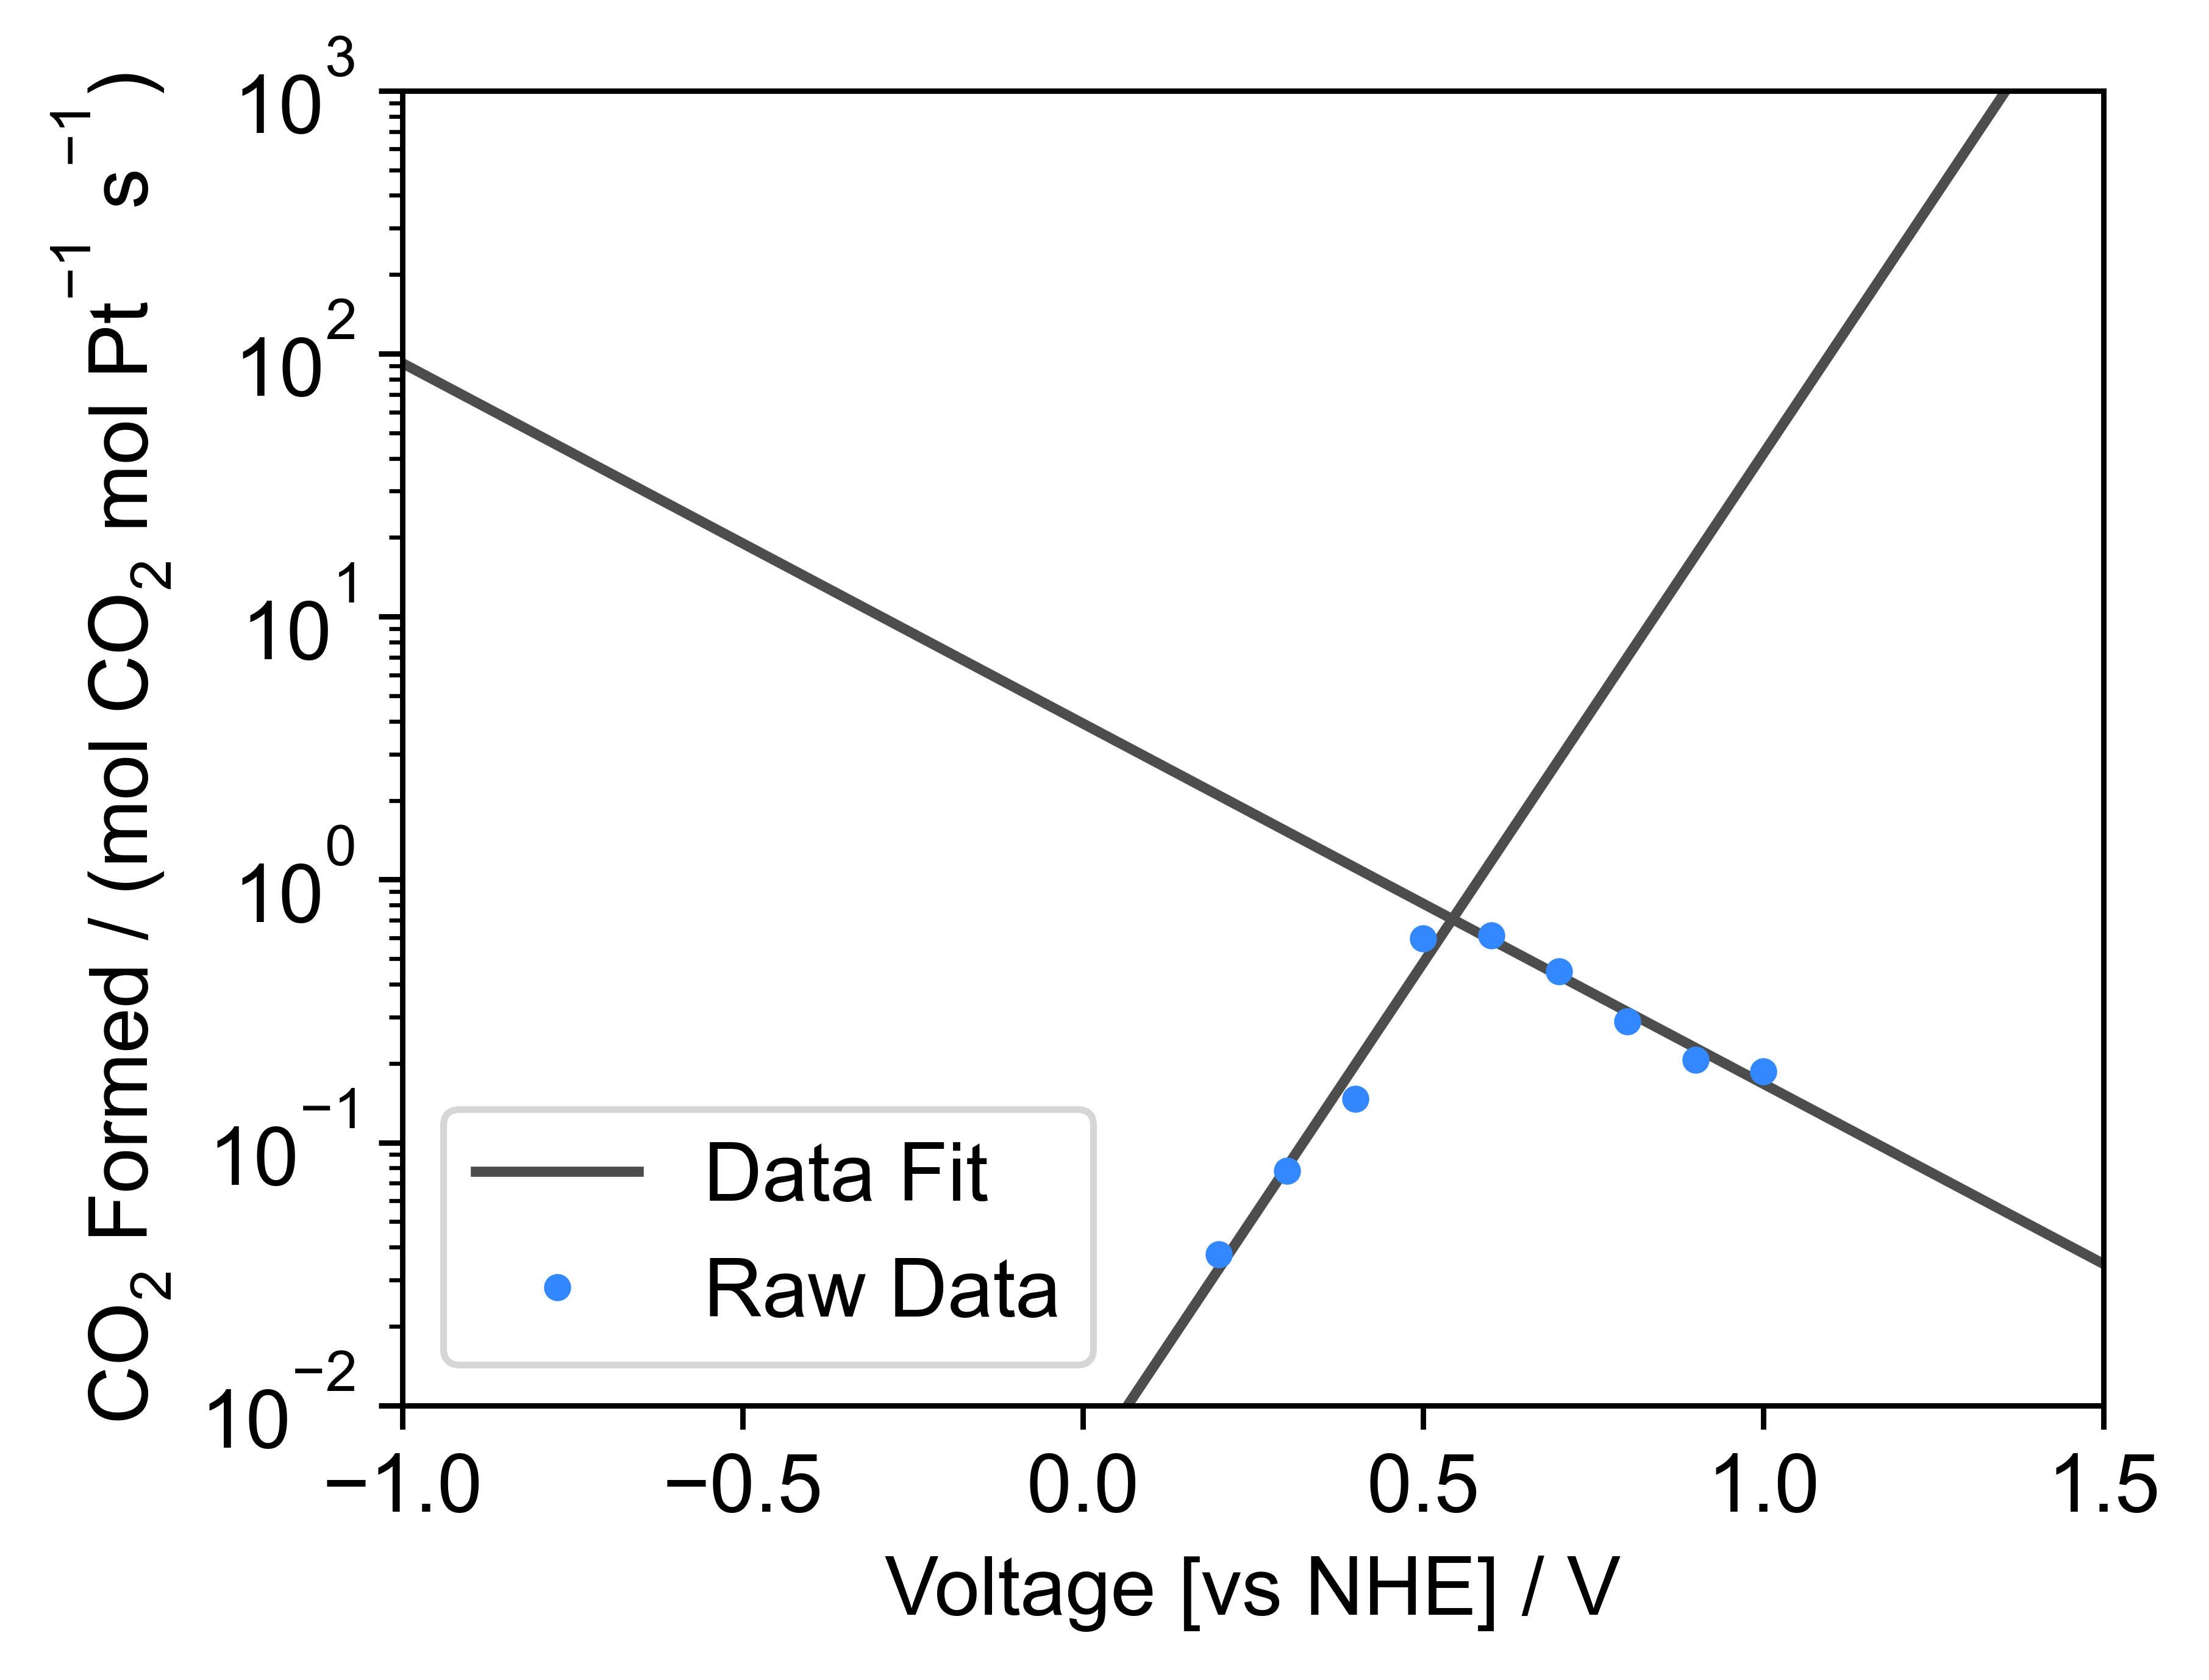

In [5]:
# Figure 1 and 6 - Sabatier volcano

# collected data (potentiostatic) doi: 10.1021/acscatal.0c02201 (obtained by figure inspection)
potential = range(0.2, 1, 9)
tof = [0.0376, 0.0779, 0.1468, 0.5955, 0.6146, 0.4469, 0.2888, 0.2067, 0.1866]

# raw data
plt.figure(figsize=(4.5, 3.5), dpi=800)

plt.semilogy(potential, tof, color=blues[5], marker="o", linestyle="", markersize=3)

plt.ylim(10^-2, 10^0)
plt.xlim(0, 1.2)
plt.xlabel("Voltage [vs NHE] / V")
plt.ylabel(L"CO$\mathregular{_2}$ Formed / (mol CO$\mathregular{_2}$ mol Pt$\mathregular{^{-1}}$ s$\mathregular{^{-1}}$)")

plt.show()

savefig("sabatier_volcano_formic.pdf", bbox_inches="tight")

# raw data with line fits
plt.figure(figsize=(4.5, 3.5), dpi=800)

x_fit_low_V, y_fit_low_V, slope, intercept, r_squared = fit_line(collect(potential[1:4]), log10.(tof[1:4]), [-1, 2.5])
plt.plot(x_fit_low_V, 10 .^y_fit_low_V, color=greys[3], label="Data Fit")

x_fit_high_V, y_fit_high_V, slope, intercept, r_squared = fit_line(collect(potential[5:end]), log10.(tof[5:end]), [-1, 2.5])
plt.plot(x_fit_high_V, 10 .^y_fit_high_V, color=greys[3])

plt.semilogy(potential, tof, color=blues[5], marker="o", linestyle="", label="Raw Data", markersize=3)

plt.ylim(10^-2, 10^3)
plt.xlim(-1, 1.5)
plt.xlabel("Voltage [vs NHE] / V")
plt.ylabel(L"CO$\mathregular{_2}$ Formed / (mol CO$\mathregular{_2}$ mol Pt$\mathregular{^{-1}}$ s$\mathregular{^{-1}}$)")
plt.legend(loc="lower left")

plt.show()

savefig("sabatier_volcano_formic_with_fits.pdf", bbox_inches="tight")

In [9]:
# Figure 5 - Outlook

figure_2, axes_2 = plt.subplots(2, 2, figsize=(13, 10), dpi=800)

# EIS recorded
# trouble importing EIS data - requires cleanup
raw_eis_data = CSV.read("/home/mgadaloff/data_sharing/raw_data/EIS/20.8C EIS Test 6/1_20.8C EIS Test 6 20241203 145529.csv", DataFrame, header=0)
eis_data = raw_eis_data[2:end, :] # remove row of column titles

# set column types
for col in [:Column1, :Column2, :Column4, :Column5, :Column6, :Column7, :Column8, :Column9, :Column10, :Column11, :Column12, :Column13, :Column14, :Column15, :Column16] # change column types
    eis_data[!, col] .= parse.(Float64, eis_data[!, col])
end

# set column names
rename!(eis_data, [:step_number, :repeats, :step_name, :time_s, :dc_working_elec_V, 
    :dc_current_A, :frequency_Hz, :abs_impedance_ohm, :phase_deg, :real_impedance_ohm, 
    :complex_impedance_ohm, :total_harmonic_distortion_percent, :amplitude_A, :amplitude_V, 
    :num_cycles, :duration_frequency_s])

axes_2[1].loglog(eis_data.frequency_Hz, eis_data.abs_impedance_ohm, color=blues[5], marker="o", linestyle="", markersize=3)

axes_2[1].set_ylim(10^3, 10^7)
axes_2[1].set_xlim(10^-1, 10^7)
axes_2[1].set_xlabel("Frequency / Hz", fontsize=14)
axes_2[1].set_ylabel("Absolute Impedance / ohm", fontsize=14)
axes_2[1].set_title("a) Recorded frequency response: impedance", loc="left", fontsize=16)


# EIS ideal
frequency = 10 .^(range(-4,stop=4,length=100))
impedance = [1/(0.001*f) + 1000*f for f in frequency]

axes_2[3].loglog(frequency, impedance,color=blues[5])
axes_2[3].set_xlim(10^-4, 10^4)
axes_2[3].set_ylim(10^3, 10^7)
axes_2[3].set_xlabel("Frequency / Hz", fontsize=14)
axes_2[3].set_ylabel("Absolute Impedance / ohm", fontsize=14)
axes_2[3].set_title("b) Ideal frequency response: impedance", loc="left", fontsize=16)

# phase shift

# use existing processed
axes_2[2].semilogx(eis_data.frequency_Hz, eis_data.phase_deg, color=blues[3], marker="o", linestyle="", markersize=3, label=L"Pre-Heating to 140 $\mathregular{^o}$C")

# trouble importing EIS data - requires cleanup
raw_eis_data = CSV.read("/home/mgadaloff/data_sharing/raw_data/EIS/test 2/1_test 2 20241204 163218.csv", DataFrame, header=0)
eis_data = raw_eis_data[2:end, :] # remove row of column titles

# set column types
for col in [:Column1, :Column2, :Column4, :Column5, :Column6, :Column7, :Column8, :Column9, :Column10, :Column11, :Column12, :Column13, :Column14, :Column15, :Column16] # change column types
    eis_data[!, col] .= parse.(Float64, eis_data[!, col])
end

# set column names
rename!(eis_data, [:step_number, :repeats, :step_name, :time_s, :dc_working_elec_V, 
    :dc_current_A, :frequency_Hz, :abs_impedance_ohm, :phase_deg, :real_impedance_ohm, 
    :complex_impedance_ohm, :total_harmonic_distortion_percent, :amplitude_A, :amplitude_V, 
    :num_cycles, :duration_frequency_s])

axes_2[2].semilogx(eis_data.frequency_Hz, eis_data.phase_deg, color=blues[6], marker="o", linestyle="", markersize=3, label=L"Post-Heating to 140 $\mathregular{^o}$C")

axes_2[2].set_ylim(-80, 10)
axes_2[2].set_xlim(10^-1, 10^7)
axes_2[2].set_xlabel("Frequency / Hz", fontsize=14)
axes_2[2].set_ylabel("Phase Shift / degree", fontsize=14)
axes_2[2].set_title("c) Recorded frequency response: phase", loc="left", fontsize=16)
axes_2[2].legend(loc="upper left")

# high-temperature shift
cyclic_v_directory = "/home/mgadaloff/data_sharing/raw_data/Temperature Tests"

# recursively find csv files
csv_file_paths = [joinpath(root, file) for (root, _, files) in walkdir(cyclic_v_directory) for file in files if endswith(file, ".csv")]

# import data and structure
raw_data = Dict(csv_path => CSV.read(csv_path, DataFrame) for csv_path in csv_file_paths)
processed_cv_data = Dict{Float64, DataFrame}()

# rename columns and remove first cycle
for (csv_path, df_data) in raw_data

    rename!(df_data, [:step_num, :repeats, :cycle, :step_name, :elapsed_time_s, 
                :working_elec_V, :working_elec_vs_NHE_V, :current_A, :abs_current_A, 
                :current_den_A_per_m2, :cumulative_charge_mAh, :counter_electrode_V])
    
    filter!(row -> row[:cycle] != 0, df_data)

    if nrow(df_data) == 0 # throw error if cv does not complete cycle 0
        throw("cv halted during cycle 0: " * csv_path)
    end

end

# obtain CV temperature from file path
for (csv_path, df_data) in raw_data

    m = match(r"\s-\sworking\s*(\d+(?:\.\d+)?)\s*C", csv_path)  # Match one or more digits followed by 'C'
    temperature = isnothing(m) ? 115.5 : parse(Float64, m[1])  # Parse as Float64
    processed_cv_data[temperature] = df_data

end

# plot CV data
for index = 1:length(processed_cv_data)
    temperature = sort(collect(keys(processed_cv_data)))[index]
    cv_data_per_cycle = processed_cv_data[temperature]

    axes_2[4].scatter(cv_data_per_cycle.working_elec_V, cv_data_per_cycle.current_A.*10^6, label=string(temperature)*L" $\mathregular{^o}$C", s=10, color=blues[(index+1)])
end

axes_2[4].set_xlim(-12, 12)
axes_2[4].set_ylim(-1, 3)
axes_2[4].legend(loc="upper left", ncol=2)
axes_2[4].set_title("d) CV at varying temperature", loc="left", fontsize=16)
axes_2[4].set_xlabel("Voltage / V", fontsize=14)
axes_2[4].set_ylabel(L"Current / (μA cm$\mathregular{^{-2}}$)", fontsize=14)

figure_2.subplots_adjust(hspace=0.3)

plt.show()

savefig("outlook_questions.pdf", bbox_inches="tight")

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
